In [117]:
# Cell 1: Import necessary libraries
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import  ModelCheckpoint
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from keras.applications import EfficientNetV2L

In [119]:
# Cell 2: Define constants
BATCH_SIZE = 16
IMG_HEIGHT = 300   #efficientnetv2s
IMG_WIDTH = 300
# IMG_HEIGHT = 300 #EfficientNetV2B3
# IMG_WIDTH = 300
# IMG_HEIGHT = 528 #EfficientNetB6
# IMG_WIDTH = 528
DATA_DIR = "/home/anon/MajorProject/Data/Dataset_alpha"

In [120]:
# Cell 3: Load data

#train and test if already separated
# TRAIN_DATA_DIR = "/home/anon/MajorProject/Data/ASL_MAIN/asl_alphabet_train"
# TEST_DATA_DIR = "/home/anon/MajorProject/Data/Synthetic_Dataset/test"

# train_ds = tf.keras.utils.image_dataset_from_directory(
#     TRAIN_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)

# val_ds = tf.keras.utils.image_dataset_from_directory(
#     TEST_DATA_DIR,
#     image_size=(IMG_HEIGHT, IMG_WIDTH),
#     batch_size=BATCH_SIZE)


train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

Found 1500 files belonging to 15 classes.
Using 1200 files for training.
Found 1500 files belonging to 15 classes.
Using 300 files for validation.
['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Left_Click', 'Nothing', 'PowerPoint_Open', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'VSCode_Open', 'Volume_Decrease', 'Volume_Increase']


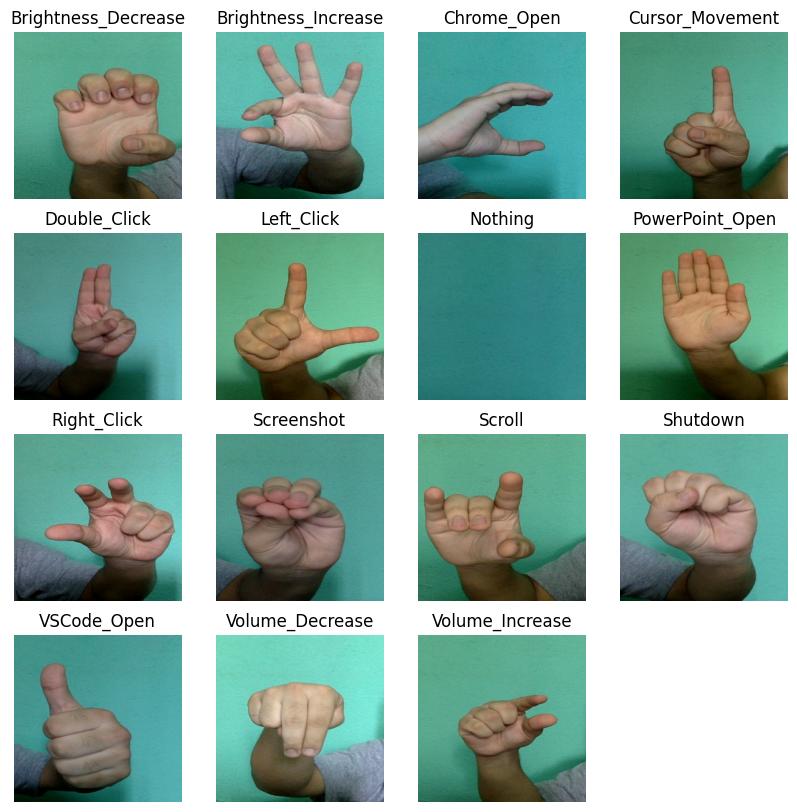

In [121]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Iterate over the images and labels in the current batch
  for image, label in zip(images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")



In [122]:
# Before data augmentation
for images, labels in train_ds.take(1):
  for image in images:
    print(image.shape)


(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


In [123]:
# Cell 4: Define data augmentation
data_augmentation = keras.Sequential(
    [
        # layers.RandomFlip("horizontal"),
        # layers.RandomRotation(0.05),
        layers.RandomZoom(0.1),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        # layers.RandomWidth(0.1),
        layers.RandomCrop(IMG_HEIGHT, IMG_HEIGHT),
    ]
)

In [125]:
# Cell 5: Preprocess data #data augmentation and one hot encoding
# train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))
# val_ds = val_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), tf.one_hot(y, num_classes)))


#no one hot encoding since class > 10:
# data augmentation
train_ds = train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y))
val_ds = val_ds.map(lambda x, y: (x, y))

In [126]:
# After data augmentation
for images, labels in train_ds.map(lambda x, y: (tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), x), y)).take(1):
    for image in images:
        print(image.shape)

(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)
(300, 300, 3)


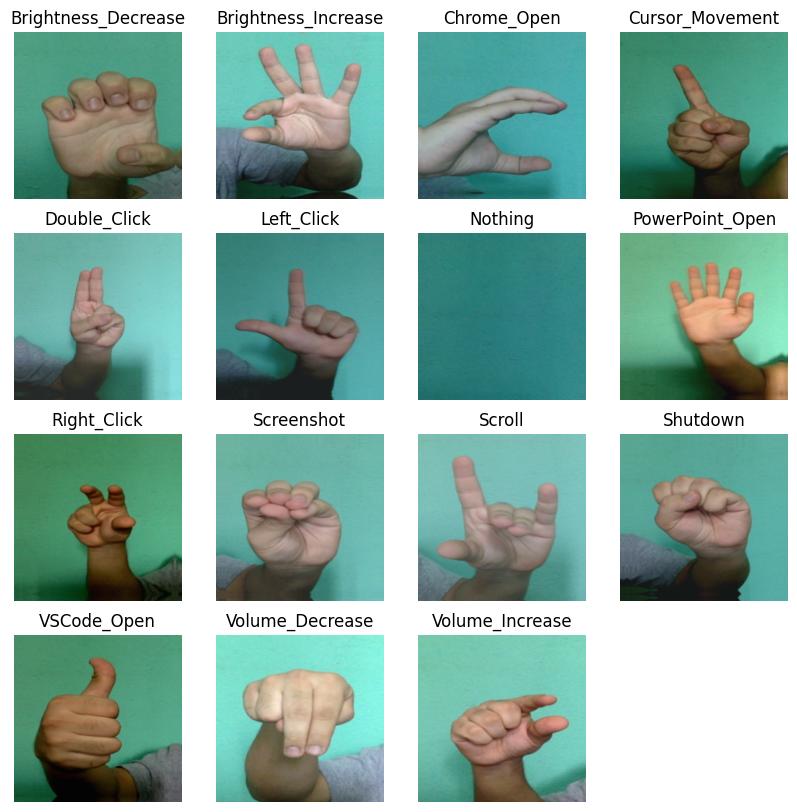

In [127]:
import math

# Calculate the number of rows and columns for the grid
num_rows = math.ceil(math.sqrt(num_classes))
num_cols = num_rows

plt.figure(figsize=(10, 10))

# Create a dictionary to store an image from each class
class_images = {class_name: None for class_name in class_names}

# Iterate over the batches
for images, labels in train_ds:
  # Apply data augmentation
  augmented_images = tf.map_fn(lambda img: tf.squeeze(data_augmentation(tf.expand_dims(img, 0)), axis=0), images)
  
  # Iterate over the images and labels in the current batch
  for image, label in zip(augmented_images, labels):
    # If we haven't stored an image for this class yet, store it
    if class_images[class_names[label]] is None:
      class_images[class_names[label]] = image

  # If we've stored an image for each class, stop iterating over the batches
  if all(image is not None for image in class_images.values()):
    break

# Plot an image for each class
for i, class_name in enumerate(class_names):
  ax = plt.subplot(num_rows, num_cols, i + 1)
  plt.imshow(class_images[class_name].numpy().astype("uint8"))
  plt.title(class_name)
  plt.axis("off")


In [129]:
# Cell 6: Build model
inputs = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3))
model = EfficientNetV2L(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.5
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = layers.Dense(num_classes, activation="softmax", name="pred", kernel_regularizer=regularizers.l2(0.01))(x)  # L2 regularization
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)  # Removed L2 regularization

# Compile
model = keras.Model(inputs, outputs, name="EfficientNet")
lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=10000, decay_rate=0.9)
optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

In [130]:
for images, labels in train_ds.take(1):
    print(f'Training images shape: {images.shape}, labels shape: {labels.shape}')

for images, labels in val_ds.take(1):
    print(f'Validation images shape: {images.shape}, labels shape: {labels.shape}')


Training images shape: (16, 300, 300, 3), labels shape: (16,)
Validation images shape: (16, 300, 300, 3), labels shape: (16,)


In [131]:
print(model.summary())

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 rescaling_7 (Rescaling)     (None, 300, 300, 3)          0         ['input_8[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 150, 150, 32)         864       ['rescaling_7[0][0]']         
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 150, 150, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                    

In [134]:
# Cell 7: Define callbacks
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint_filepath = '/home/anon/MajorProject/Non_Git/Checkpoints/Dataset_alpha/checkpoint-{epoch:02d}-{val_accuracy:.4f}.h5'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True)

In [135]:
#Cell 8 train the model
epochs = 30
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[early_stopping, model_checkpoint,reduce_lr])

Epoch 1/30
75/75 [==============================] - ETA: 0s - loss: 3.4317 - accuracy: 0.1842 - sparse_categorical_accuracy: 0.1842 - sparse_top_k_categorical_accuracy: 0.5375

/home/anon/miniconda3/envs/major_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 33s 201ms/step - loss: 3.4317 - accuracy: 0.1842 - sparse_categorical_accuracy: 0.1842 - sparse_top_k_categorical_accuracy: 0.5375 - val_loss: 2.7121 - val_accuracy: 0.3833 - val_sparse_categorical_accuracy: 0.3833 - val_sparse_top_k_categorical_accuracy: 0.7767 - lr: 9.9922e-05
Epoch 2/30
75/75 [==============================] - 10s 131ms/step - loss: 2.5770 - accuracy: 0.3367 - sparse_categorical_accuracy: 0.3367 - sparse_top_k_categorical_accuracy: 0.7175 - val_loss: 2.3854 - val_accuracy: 0.6100 - val_sparse_categorical_accuracy: 0.6100 - val_sparse_top_k_categorical_accuracy: 0.9067 - lr: 9.9843e-05
Epoch 3/30
75/75 [==============================] - 10s 133ms/step - loss: 2.0028 - accuracy: 0.4700 - sparse_categorical_accuracy: 0.4700 - sparse_top_k_categorical_accuracy: 0.8500 - val_loss: 1.9906 - val_accuracy: 0.7200 - val_sparse_categorical_accuracy: 0.7200 - val_sparse_top_k_categorical_accuracy: 0.9367 - lr: 9.9764e-05
Epoch 4/30
75/7

In [136]:
# Cell 10: Save the model
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2L_300x300_Dataset_alpha.h5')

In [137]:
#for categorical_crossentropy
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)


#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 36ms/step


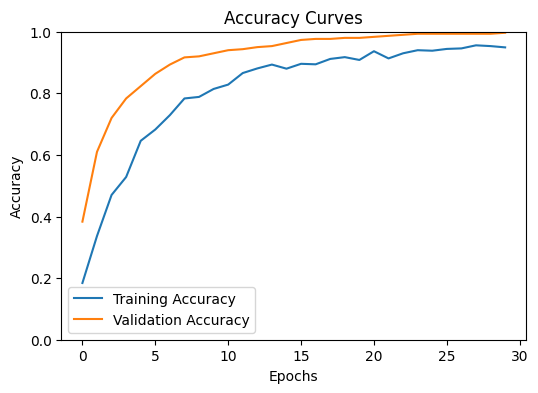

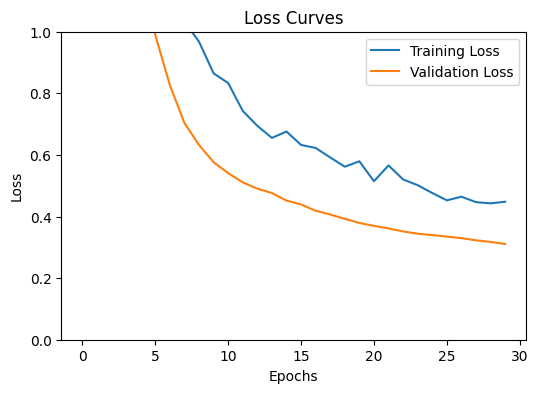

In [138]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()


Accuracy: 0.9966666666666667
Precision: 0.9962962962962963
Recall: 0.9972222222222222
F1 Score: 0.9966767983789261
AUC-ROC: 0.998493325480958


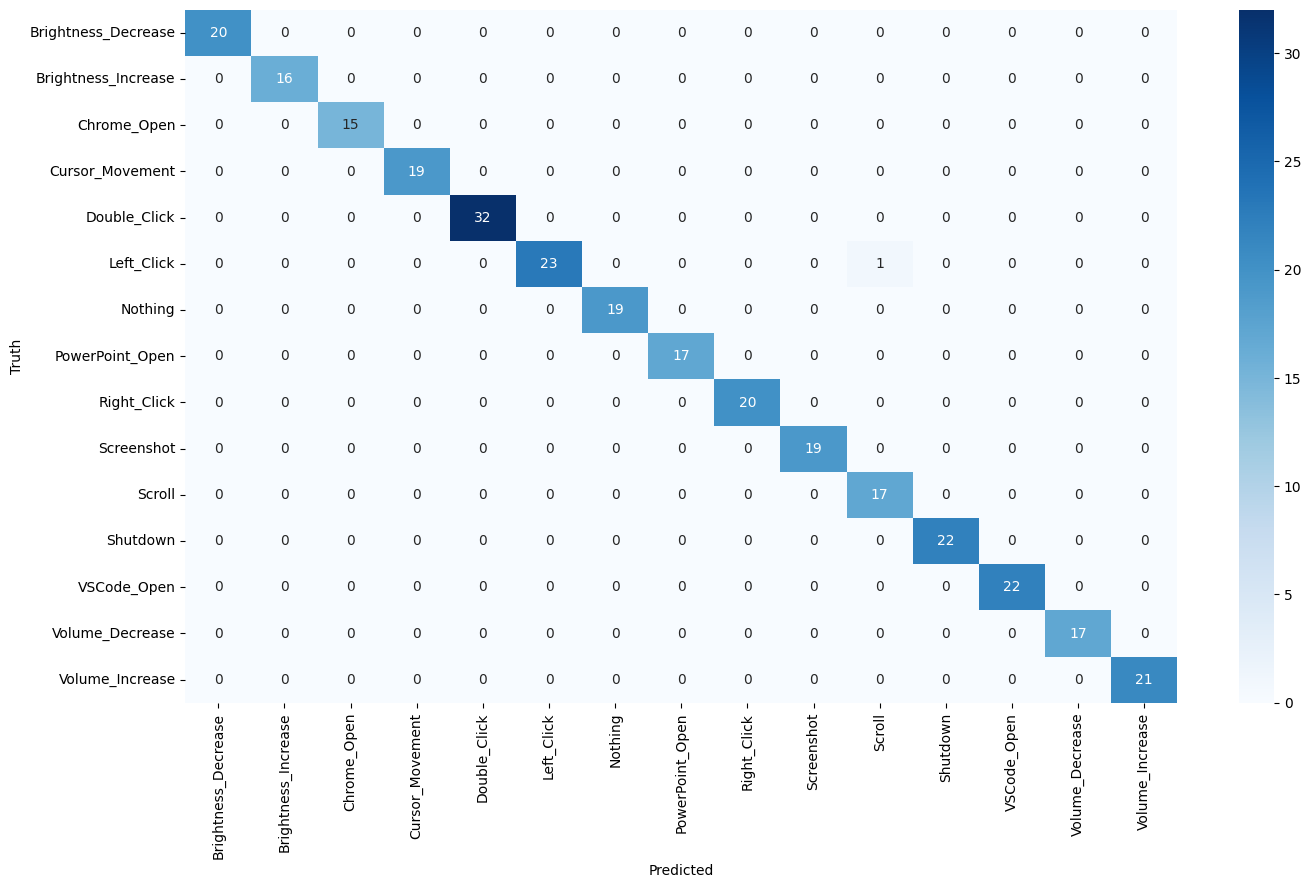

In [139]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score
average = 'macro'  # or 'micro', 'weighted', depending on the problem
precision = precision_score(y_true, y_pred, average=average)
recall = recall_score(y_true, y_pred, average=average)
f1 = f1_score(y_true, y_pred, average=average)

# AUC-ROC for multiclass
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

#for dataset_alpha
class_names = ['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Left_Click', 'Nothing', 'PowerPoint_Open', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'VSCode_Open', 'Volume_Decrease', 'Volume_Increase']


# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# class_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [140]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_8
1 rescaling_7
2 stem_conv
3 stem_bn
4 stem_activation
5 block1a_project_conv
6 block1a_project_bn
7 block1a_project_activation
8 block1a_add
9 block1b_project_conv
10 block1b_project_bn
11 block1b_project_activation
12 block1b_drop
13 block1b_add
14 block1c_project_conv
15 block1c_project_bn
16 block1c_project_activation
17 block1c_drop
18 block1c_add
19 block1d_project_conv
20 block1d_project_bn
21 block1d_project_activation
22 block1d_drop
23 block1d_add
24 block2a_expand_conv
25 block2a_expand_bn
26 block2a_expand_activation
27 block2a_project_conv
28 block2a_project_bn
29 block2b_expand_conv
30 block2b_expand_bn
31 block2b_expand_activation
32 block2b_project_conv
33 block2b_project_bn
34 block2b_drop
35 block2b_add
36 block2c_expand_conv
37 block2c_expand_bn
38 block2c_expand_activation
39 block2c_project_conv
40 block2c_project_bn
41 block2c_drop
42 block2c_add
43 block2d_expand_conv
44 block2d_expand_bn
45 block2d_expand_activation
46 block2d_project_conv
47 block2d_pr

In [141]:
# Cell 9: Unfreeze model and continue training
# for layer in model.layers[-20:]:
#     if not isinstance(layer, layers.BatchNormalization):
#         layer.trainable = True

# # we chose to train the top 2 blocks, i.e. we will freeze
# # the first xxx layers and unfreeze the rest:
# for layer in model.layers[:514]:
#    layer.trainable = False
# for layer in model.layers[514:]:
#    layer.trainable = True
# # we need to recompile the model for these modifications to take effect
# # we train our model again (this time fine-tuning the top 2 blocks
# # alongside the top Dense layers
# optimizer = keras.optimizers.Adam(learning_rate=1e-5)
# model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

# epochs = 5
# hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

for layer in model.layers[:1029]:
   layer.trainable = False
for layer in model.layers[1029:]:
   if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy", metrics=["accuracy","SparseCategoricalAccuracy", "SparseTopKCategoricalAccuracy"])

epochs = 10
hist = model.fit(train_ds, epochs=epochs, validation_data=val_ds)


Epoch 1/10
75/75 [==============================] - 30s 155ms/step - loss: 0.4145 - accuracy: 0.9650 - sparse_categorical_accuracy: 0.9650 - sparse_top_k_categorical_accuracy: 1.0000 - val_loss: 0.3109 - val_accuracy: 0.9967 - val_sparse_categorical_accuracy: 0.9967 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 2/10
75/75 [==============================] - 8s 104ms/step - loss: 0.4551 - accuracy: 0.9483 - sparse_categorical_accuracy: 0.9483 - sparse_top_k_categorical_accuracy: 0.9992 - val_loss: 0.3110 - val_accuracy: 0.9967 - val_sparse_categorical_accuracy: 0.9967 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 3/10
75/75 [==============================] - 8s 105ms/step - loss: 0.4408 - accuracy: 0.9583 - sparse_categorical_accuracy: 0.9583 - sparse_top_k_categorical_accuracy: 0.9983 - val_loss: 0.3111 - val_accuracy: 0.9967 - val_sparse_categorical_accuracy: 0.9967 - val_sparse_top_k_categorical_accuracy: 1.0000
Epoch 4/10
75/75 [==============================] - 8s 10

In [142]:
# import numpy as np

# # Initialize lists to store the true and predicted labels
# y_true = []
# y_pred = []

# # Iterate over the validation dataset
# for images, labels in val_ds:
#     # Get the model's predictions
#     pred_probs = model.predict(images)

#     # Convert the predicted probabilities to class labels
#     preds = np.argmax(pred_probs, axis=1)

#     # Convert one-hot encoded labels back to class labels
#     labels = np.argmax(labels.numpy(), axis=1)

#     # Append the labels to the lists
#     y_true.extend(labels)
#     y_pred.extend(preds)

# # Convert the lists to numpy arrays
# y_true = np.array(y_true)
# y_pred = np.array(y_pred)

#for sparse_categorical_crossentropy
import numpy as np

# Initialize lists to store the true and predicted labels
y_true = []
y_pred = []

# Iterate over the validation dataset
for images, labels in val_ds:
    # Get the model's predictions
    pred_probs = model.predict(images)

    # Convert the predicted probabilities to class labels
    preds = np.argmax(pred_probs, axis=1)

    # Append the labels to the lists
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

# Convert the lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 [==============================] - 0s 37ms/step


Accuracy: 0.9933333333333333
Precision: 0.992982456140351
Recall: 0.9944444444444444
F1 Score: 0.9933977455716586
AUC-ROC: 0.9969866509619159


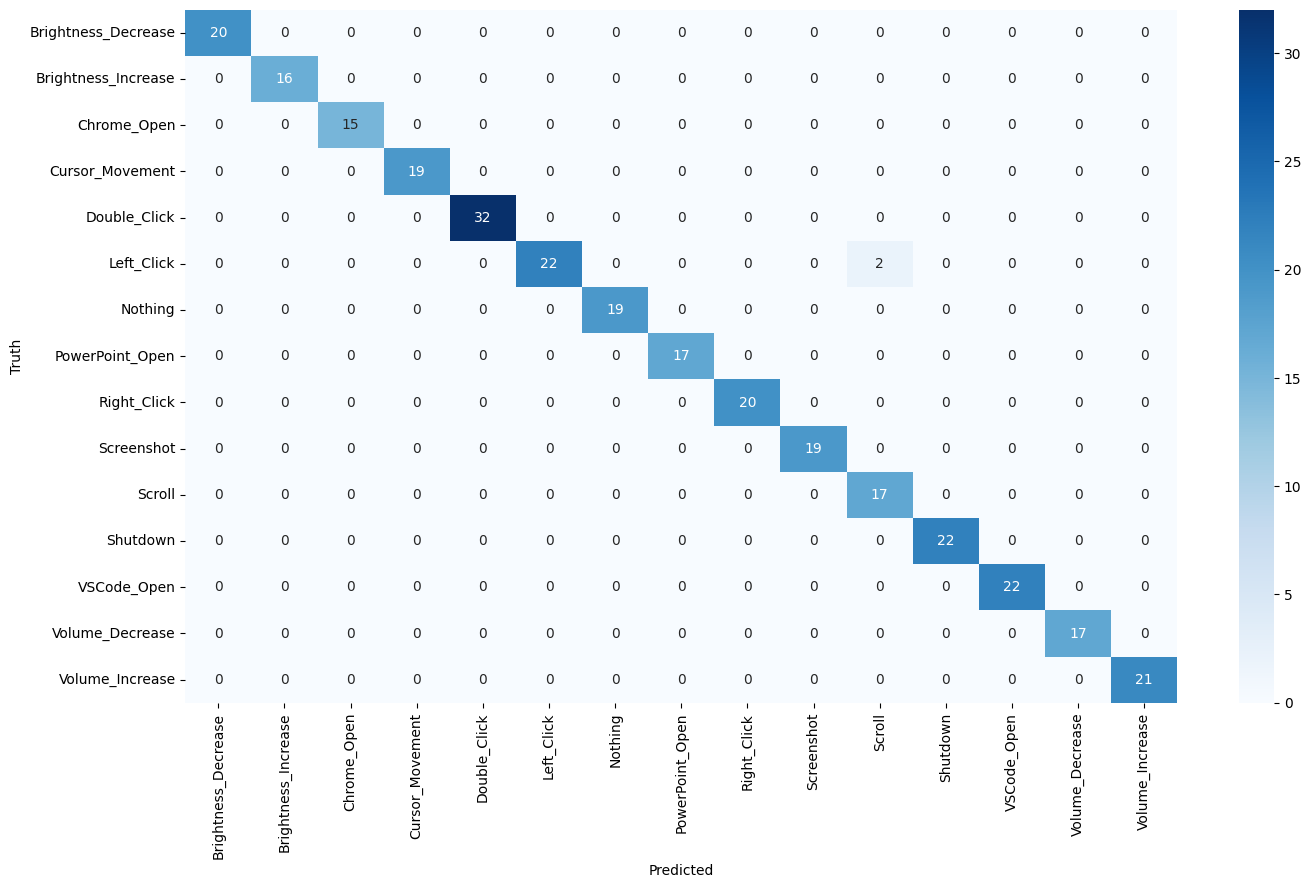

In [143]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
accuracy = accuracy_score(y_true, y_pred)

# Precision, Recall, F1 Score
average = 'macro'  # or 'micro', 'weighted', depending on the problem
precision = precision_score(y_true, y_pred, average=average)
recall = recall_score(y_true, y_pred, average=average)
f1 = f1_score(y_true, y_pred, average=average)

# AUC-ROC for multiclass
lb = LabelBinarizer()
lb.fit(y_true)
y_true_lb = lb.transform(y_true)
y_pred_lb = lb.transform(y_pred)
auc_roc = roc_auc_score(y_true_lb, y_pred_lb, average=average, multi_class='ovr')

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC-ROC: {auc_roc}")

#for dataset_alpha
class_names = ['Brightness_Decrease', 'Brightness_Increase', 'Chrome_Open', 'Cursor_Movement', 'Double_Click', 'Left_Click', 'Nothing', 'PowerPoint_Open', 'Right_Click', 'Screenshot', 'Scroll', 'Shutdown', 'VSCode_Open', 'Volume_Decrease', 'Volume_Increase']


# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

# class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# class_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
# class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# # Plot confusion matrix as a heatmap
# plt.figure(figsize=(10,7))
# sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
# plt.show()

# Plot confusion matrix as a heatmap
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [144]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Convert the true and predicted labels to a binary matrix
lb = LabelBinarizer()
lb.fit(y_true)
y_true_bin = lb.transform(y_true)
y_pred_bin = lb.transform(y_pred)

# Calculate the macro-averaged AUC-ROC
auc_roc_macro = roc_auc_score(y_true_bin, y_pred_bin, average='macro', multi_class='ovr')
print(f"Macro-Averaged AUC-ROC: {auc_roc_macro}")


Macro-Averaged AUC-ROC: 0.9969866509619159


In [145]:
model.save('/home/anon/MajorProject/Non_Git/Models/EfficientNetV2L_300x300_Dataset_alpha_finetuned.h5')

/home/anon/miniconda3/envs/major_tf/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


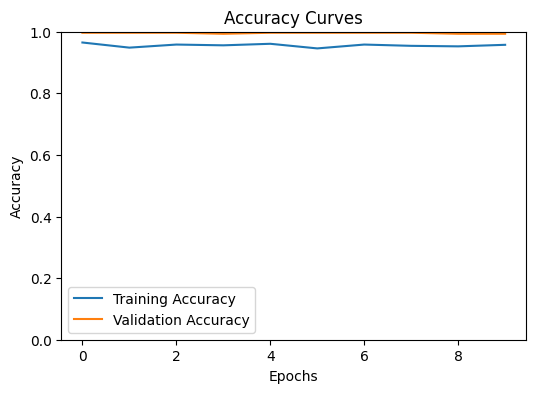

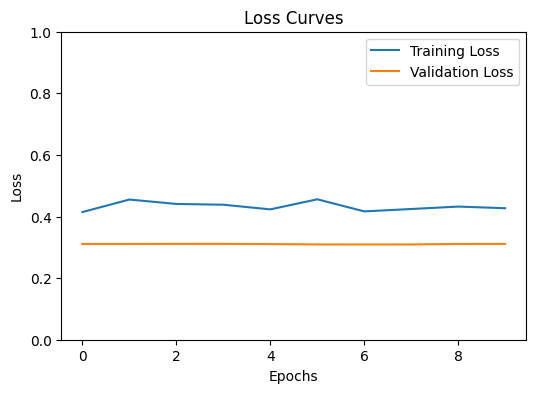

In [146]:
import matplotlib.pyplot as plt

# Plotting the Accuracy Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['accuracy'], linewidth=1.5)
plt.plot(hist.history['val_accuracy'], linewidth=1.5)
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()

# Plotting the Loss Curve
plt.figure(figsize=[6,4])
plt.plot(hist.history['loss'], linewidth=1.5)
plt.plot(hist.history['val_loss'], linewidth=1.5)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.ylim([0, 1])  # Set the limits of the y-axis here
plt.show()
